In [106]:
import random
import numpy as np
from game import Game, Move, Player
from copy import deepcopy
from tqdm import tqdm

border = []
for i in range(5):
    for j in range(5):
        if i == 0 or i == 4 or j == 0 or j == 4:
            border.append((i, j))
BORDER = (list(set(border)))
print(len(BORDER))

ALL_MOVES = []
for pos in BORDER:
    possible_moves = [Move.TOP, Move.BOTTOM, Move.LEFT, Move.RIGHT]
            
    if pos[0] == 0: possible_moves.remove(Move.LEFT)
    if pos[0] == 4: possible_moves.remove(Move.RIGHT)
    if pos[1] == 0: possible_moves.remove(Move.TOP)
    if pos[1] == 4: possible_moves.remove(Move.BOTTOM)

    for move in possible_moves: ALL_MOVES.append((pos, move))
N_ALL = len(ALL_MOVES)

class RandomPlayer(Player):
    def __init__(self) -> None:
        super().__init__()

    def make_move(self, game: 'Game') -> tuple[tuple[int, int], Move]:

        from_pos = random.choice(BORDER)
        while game.get_board()[from_pos[1], from_pos[0]] == 1 - game.current_player_idx: from_pos = random.choice(BORDER)

        possible_moves = [Move.TOP, Move.BOTTOM, Move.LEFT, Move.RIGHT]
            
        if from_pos[0] == 0: possible_moves.remove(Move.LEFT)
        if from_pos[0] == 4: possible_moves.remove(Move.RIGHT)
        if from_pos[1] == 0: possible_moves.remove(Move.TOP)
        if from_pos[1] == 4: possible_moves.remove(Move.BOTTOM)
        
        move = random.choice(possible_moves)

        return from_pos, move

16


In [107]:
class ID_generator:
    def __init__(self):
        self.id = -1
    def get_id(self):
        self.id += 1
        return self.id

In [108]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [109]:
def rot(n_rot):
    def rot_n(board): 
        return np.rot90(board, k= n_rot)
    return rot_n

def flip_rot(n_rot):
    def flip_rot_n(board): 
        return np.rot90(np.fliplr(board), k= n_rot)
    return flip_rot_n

rot2 = rot(2)
rot3 = rot(3)
flip_rot1 = flip_rot(1)
flip_rot2 = flip_rot(2)
flip_rot3 = flip_rot(3)

In [110]:
# weight definition
INPUT_SHAPE = (3, 5, 5)
INPUT_SHAPE = (24, 5, 5)
WEIGHT_SHAPE = np.array([
    [
        ('dense', 256),
        ('dense', 128),
        ('dense', 64),
        ('dense', N_ALL),
    ],
    [
        ('dense', 128),
        ('dense', 64),
        ('dense', N_ALL),
    ],
    [
        ('dense', 128),
        ('dense', 64),
        ('dense', N_ALL),
    ],
], dtype= object)

def multiply(x):
    res = 1
    for xx in x: res *= xx
    return res

class MyPlayer(Player):
    def __init__(self, id, heritage= None) -> None:
        super().__init__()

        self.id = id

        if heritage is None:
            self.W = []
            self.b = []

            for branch in WEIGHT_SHAPE:
                branch_w = []
                branch_b = []
                in_shape = INPUT_SHAPE

                for layer in branch:
                    #print(in_shape)
                    #print(layer)

                    if layer[0] == 'dense':
                        in_shape = multiply(in_shape)
                        branch_w.append(np.random.random(size= (in_shape, layer[1])))
                        branch_b.append(np.random.random(size= (layer[1],)))
                        in_shape = (layer[1],)

                    elif layer[0] == 'conv':

                        if len(in_shape) == 2:
                            branch_w.append(np.random.random(size= layer[1]))
                            branch_b.append(np.random.random(size= (layer[1][0],)))
                            in_shape = (layer[1][0], in_shape[0] - layer[1][1] + 1, in_shape[1] - layer[1][2] + 1)

                        else:
                            branch_w.append(np.random.random(size= (layer[1][0] * in_shape[0], layer[1][1], layer[1][2])))
                            branch_b.append(np.random.random(size= (layer[1][0] * in_shape[0],)))
                            in_shape = (layer[1][0] * in_shape[0], in_shape[1] - layer[1][1] + 1, in_shape[2] - layer[1][2] + 1)

                    else: print('error')

                    #print(branch_w[-1].shape)
                    #print(branch_b[-1].shape)
                    #print('-')

                    #print(in_shape)
                #print('-----')

                self.W.append(branch_w)
                self.b.append(branch_b)

            self.W = np.array(self.W, dtype= object)
            self.b = np.array(self.b, dtype= object)

        else:
            self.W = heritage[0]
            self.b = heritage[1]

        self.fitness = 0
        self.until_surrend = 100
        self.epoch_before_death = 3
        self.move_list = []

    def get_id(self): return self.id
    def reset_fitness(self) -> None: self.fitness = 0
    def mod_fitness(self, mod) -> None: self.fitness += mod
    def get_fitness(self): return self.fitness
    def set_fitness(self, new_value) -> None: self.fitness = new_value
    def get_weights(self): return self.W
    def get_biases(self): return self.b
    def prepare_to_surrend(self, amount= 100)-> None: self.until_surrend = amount
    def get_death(self, bonus= None):
        if bonus is not None: self.epoch_before_death = bonus + 1
        self.epoch_before_death -= 1
        return self.epoch_before_death
    def reset_moves(self): self.moves = []
    def pool_mod_fitness(self, list_of_moves, win):

        # first try

        #c = 0
        #limit = min([len(list_of_moves), len(self.move_list)])
        #while list_of_moves[c] == self.move_list[c]:
        #    c += 1
        #    if c > limit - 1: break
        #self.fitness += c * win

        # second try
        
        c = 0
        for m_all, m in zip(list_of_moves, self.move_list):
            if m_all == m: c += 1
        
        self.fitness += c * win

        # o magari bilanciare sul numero di mosse ( ( c - ( tot_mosse // 2 ) ) * win )

        # third try

        #c = 0
        #for m_all, m in zip(list_of_moves, self.move_list):
        #    if m_all == m: c += 1
        #
        #self.fitness += (c - (len(list_of_moves) // 2)) * win

        #

        self.move_list = []
        
    
    def compute_move(self, X):
        branch_outputs = []

        for i_branch in range(len(self.W)):
            layer_input = deepcopy(X)

            for i_layer in range(len(self.W[i_branch])):
                layer_info = WEIGHT_SHAPE[i_branch][i_layer]

                if layer_info[0] == 'dense':
                    layer_output = np.dot(layer_input.flatten(), self.W[i_branch][i_layer]) + self.b[i_branch][i_layer]
                
                elif layer_info[0] == 'conv':

                    if len(layer_input.shape) == 2:
                        layer_output = np.zeros((layer_info[1][0], layer_input.shape[0] - layer_info[1][1] + 1, layer_input.shape[1] - layer_info[1][2] + 1))
                        for k in range(layer_output.shape[0]):
                            for i in range(layer_output.shape[1]):
                                for j in range(layer_output.shape[2]):
                                    layer_output[k, i, j] = sum(sum(layer_input[i:i+layer_info[1][1], j:j+layer_info[1][2]] * self.W[i_branch][i_layer][k]))
                    
                    else:
                        layer_output = np.zeros((layer_info[1][0] * layer_input.shape[0], layer_input.shape[1] - layer_info[1][1] + 1, layer_input.shape[2] - layer_info[1][2] + 1))
                        for k_in in range(layer_input.shape[0]):
                            for k in range(layer_info[1][0]):
                                for i in range(layer_output.shape[1]):
                                    for j in range(layer_output.shape[2]):
                                        layer_output[k_in*layer_info[1][0]+k, i, j] = sum(sum(layer_input[k_in, i:i+layer_info[1][1], j:j+layer_info[1][2]] * self.W[i_branch][i_layer][k_in*layer_info[1][0]+k]))
                
                else: print('error')

                layer_output = sigmoid(layer_output)

                layer_input = layer_output
                #print(f'{(i_branch, i_layer)} -> {layer_output.shape}')
            
            branch_outputs.append(layer_output)

        output = np.sum(branch_outputs, axis= 0)
        output = np.argmax(output)
        
        return output


    def make_move(self, game: 'Game', pool= False) -> tuple[tuple[int, int], Move]:

        self.until_surrend -= 1
        if self.until_surrend == 0:
            #print('surrendering')
            self.fitness -= 100
            return (-1, -1), None
        
        ## provare a generare tre mappe dalla board, una per ogni [-1, 0, 1] con 1 se [-1, 0, 1] in tile e 0 se altre
        #--------------------------------------

        board = game.get_board()
        X = np.zeros((3, board.shape[0], board.shape[1]))
        X[0][board == -1] = 1
        X[1][board == 0] = 1
        X[2][board == 1] = 1

        ######################################
        
        ## provare a generare una mappa per simmetria
        #--------------------------------------

        X2 = np.zeros((24, board.shape[0], board.shape[1]))
        c = 0
        for x in X:
            X2[c] = x
            c += 1
            for sim in [np.rot90, rot2, rot3, np.fliplr, flip_rot1, flip_rot2, flip_rot3]:
                X2[c] = sim(x)
                c += 1
        X = X2

        ######################################
        
        # invert the board based on player_turn to better recognize enemies from allies
        #--------------------------------------
        
        if game.current_player_idx == 1: pass
        else:
            tmp = deepcopy(X[1])
            X[1] = deepcopy(X[2])
            X[2] = tmp

        #######################################

        # compute move
        #--------------------------------------
            
        id_move = self.compute_move(X)

        if pool:
            self.move_list.append(id_move)
            return id_move

        from_pos, move = ALL_MOVES[id_move]

        #######################################

        # random move if illegal move chosen with penalty
        #--------------------------------------

        if game.get_board()[from_pos[1], from_pos[0]] == 1 - game.current_player_idx:

            #print('random used - penalty')
            self.fitness -= 50

            from_pos = random.choice(BORDER)
            while game.get_board()[from_pos[1], from_pos[0]] == 1 - game.current_player_idx: from_pos = random.choice(BORDER)

            possible_moves = [Move.TOP, Move.BOTTOM, Move.LEFT, Move.RIGHT]
                
            if from_pos[0] == 0: possible_moves.remove(Move.LEFT)
            if from_pos[0] == 4: possible_moves.remove(Move.RIGHT)
            if from_pos[1] == 0: possible_moves.remove(Move.TOP)
            if from_pos[1] == 4: possible_moves.remove(Move.BOTTOM)
            
            move = random.choice(possible_moves)

        #######################################
            
        # removing 1 to fitness for each move to force active play
        #--------------------------------------
        
        self.fitness -= 1

        #######################################
        
        return from_pos, move
    
class Pooling(Player):
    def __init__(self, population) -> None:
        super().__init__()

        self.population = population
        self.move_list = []
        self.until_surrend = 50

        for p in population:
            p.reset_moves()
            p.reset_fitness()

    def prepare_to_surrend(self, amount= 50): self.until_surrend = amount

    def make_move(self, game: 'Game') -> tuple[tuple[int, int], Move]:

        vote = np.zeros((N_ALL,))
        for p in self.population:
            p_vote = p.make_move(game, pool= True)
            
            vote[p_vote] += 1# + p.get_fitness()

        id_move = np.argmax(vote)

        from_pos, _ = ALL_MOVES[id_move]
        while game.get_board()[from_pos[1], from_pos[0]] == 1 - game.current_player_idx:
            id_move = np.random.randint(0, N_ALL)
            from_pos, _ = ALL_MOVES[id_move]

        self.move_list.append(id_move)

        return ALL_MOVES[id_move]
    
    def end_of_game(self, win):

        for p in self.population:
            p.pool_mod_fitness(self.move_list, win)

        self.move_list = []


In [111]:
id_gen = ID_generator()
player = Pooling([MyPlayer(id_gen.get_id()) for _ in range(10)])
game = Game()
player.make_move(game)

((2, 4), <Move.LEFT: 2>)

In [112]:
N_TRIALS = 20

## maybe N_TRIALS should depend on N_ALL

## magari provare training a votazione, ogni mossa tutti controllano e votano, alla fine se vincono si aggiunge ad ognuno un tot in base a quanto hanno
## seguito il percorso vincente, altrimenti si toglie quell'ammontare. piu trials per epoca
## sicuramente sara lento, ma potrebbe ridurre la randomicita che rende difficile comparare gli agenti e potrebbe anche aiutare la diversificazione

def evaluate_population(population, fs= None):

    pool_agent = Pooling(population)

    for _ in tqdm(range(N_TRIALS)):
    #for _ in range(N_TRIALS):

        pool_agent.prepare_to_surrend()

        if fs is None or fs == 'onlyfirst':
            pool_agent.end_of_game((1 - Game().play(pool_agent, RandomPlayer())) * 2 - 1)

        if fs is None or fs == 'onlysecond':
            pool_agent.end_of_game(Game().play(RandomPlayer(), pool_agent) * 2 - 1)
            

In [113]:
def procreate_1(p1, p2, c1, c2, id):
    
    W1 = p1.get_weights()
    b1 = p1.get_biases()
    W2 = p2.get_weights()
    b2 = p2.get_biases()

    W3 = deepcopy(W1)
    b3 = deepcopy(b1)

    c = c1 / (c1 + c2)

    for i in range(len(W1)):
        for j in range(len(W1[i])):
            if c < np.random.random():
                W3[i][j] = W2[i][j]
                b3[i][j] = b2[i][j]

    return MyPlayer(id, heritage= (W3, b3))

def procreate_2(p1, p2, c1, c2, id):
    
    W1 = p1.get_weights()
    b1 = p1.get_biases()
    W2 = p2.get_weights()
    b2 = p2.get_biases()

    W3 = deepcopy(W1)
    b3 = deepcopy(b1)

    c = c1 / (c1 + c2)

    for i in range(len(W1)):
        if c < np.random.random():
            W3[i] = W2[i]
            b3[i] = b2[i]

    return MyPlayer(id, heritage= (W3, b3))

def softmax_temp(x, t= 1):
    e_x = np.exp(x / t)
    return e_x / sum(e_x)

def procreation(population, id_generator):
        
    mod_scores = softmax_temp(np.array([p.get_fitness() for p in population]), 1000)
    
    parents = []
    for _ in range(15):
        parents.append(np.random.choice([i for i in range(len(population))], size= (2,), replace= False, p= mod_scores))

    childrens = []
    for pair in parents:
        pi = population[pair[0]]
        pj = population[pair[1]]
        mod_i = mod_scores[pair[0]]
        mod_j = mod_scores[pair[1]]
        
        rand = np.random.random()
        if 0.5 >= rand:
            childrens.append(procreate_1(pi, pj, mod_i, mod_j, id_generator.get_id()))
        else:
            childrens.append(procreate_2(pi, pj, mod_i, mod_j, id_generator.get_id()))

    return childrens

In [114]:
P_MUTATION = 0.1
MUTATION_STRENGTH = 0.1

def mutate_1(p, id):

    Wm = deepcopy(p.get_weights())
    bm = deepcopy(p.get_biases())

    for i in range(len(Wm)):
        for j in range(len(Wm[i])):

            for ii in range(Wm[i][j].shape[0]):
                for jj in range(Wm[i][j].shape[1]):
                    if P_MUTATION >= np.random.random():
                        Wm[i][j][ii, jj] += np.random.normal(0, MUTATION_STRENGTH, size= Wm[i][j][ii, jj].shape)

            for ii in range(bm[i][j].shape[0]):
                if P_MUTATION >= np.random.random():
                    bm[i][j][ii] += np.random.normal(0, MUTATION_STRENGTH, size= bm[i][j][ii].shape)

    return MyPlayer(id, heritage= (Wm, bm))

def mutate_2(p, id):

    Wm = deepcopy(p.get_weights())
    bm = deepcopy(p.get_biases())

    for i in range(len(Wm)):
        for j in range(len(Wm[i])):
            if P_MUTATION >= np.random.random():
                Wm[i][j] += np.random.normal(0, MUTATION_STRENGTH, size= Wm[i][j].shape)
            if P_MUTATION >= np.random.random():
                bm[i][j] += np.random.normal(0, MUTATION_STRENGTH, size= bm[i][j].shape)

    return MyPlayer(id, heritage= (Wm, bm))

def mutation(population, id_generator):

    bases = np.random.choice([i for i in range(len(population))], size= (15,), replace= False)

    mutants = []
    for base in bases:
        p = population[base]
        rand = np.random.random()
        if 0.5 >= rand:
            mutants.append(mutate_1(p, id_generator.get_id()))
        else:
            mutants.append(mutate_2(p, id_generator.get_id()))

    return mutants

In [115]:
MAX_EPOCH = 10
MAX_POPULATION = 50

id_generator = ID_generator()

population = [MyPlayer(id_generator.get_id()) for _ in range(MAX_POPULATION)]

ids = []
ps = []
tot_scores = []
times = []

for epoch in range(MAX_EPOCH):

    print(f'------------------------------------\nepoch {epoch}')

    evaluate_population(population)
    #evaluate_population(population, avg_player= population[len(population) // 2])
    scores = np.array([p.get_fitness() for p in population])

    idx_sort = np.argsort(scores)[::-1]
    scores = scores[idx_sort]
    population = [population[i] for i in idx_sort]

    print(scores[:10])
    print([p.get_id() for p in population[:10]])

    # compute avg ranking
    #--------------------------------------

    for p, s in zip(population, scores):
        p_id = p.get_id()

        if p_id in ids:
            idx = np.argwhere(np.array(ids) == p_id)[0][0]
            tot_scores[idx] += s
            times[idx] += 1

        else:
            ids.append(p_id)
            ps.append(p)
            tot_scores.append(s)
            times.append(1)

    #######################################

    # provare ad implementare morte dopo tot che non si è tra i primi tot
    #--------------------------------------

    to_death = []
    for i, p in enumerate(population):
        bonus_epochs = 4 if i < MAX_POPULATION / 2 else None
        if p.get_death(bonus_epochs) == 0: to_death.append(p)
    for p in to_death: population.remove(p)

    #######################################

    ## magari aumentare e diminuire aumento popolazione in base a grandezza popolazione

    print(f'before: {len(population)}')

    ## procreazione (probabilita dipendente da fitness)

    childrens = procreation(population, id_generator)
    print(f'n_childrens: {len(childrens)}')

    ## mutazioni (tante ma random su individui random)

    mutants = mutation(population, id_generator)
    print(f'n_mutants: {len(mutants)}')

    for child in childrens: population.append(child)
    for mutant in mutants: population.append(mutant)

    print(f'after: {len(population)}')

    #

------------------------------------
epoch 0


100%|██████████| 20/20 [00:31<00:00,  1.59s/it]


[ -96  -96  -96  -97  -98  -99 -100 -100 -100 -100]
[24, 7, 21, 45, 16, 33, 1, 15, 4, 17]
before: 50
n_childrens: 15
n_mutants: 15
after: 80
------------------------------------
epoch 1


100%|██████████| 20/20 [00:44<00:00,  2.22s/it]


[9 6 5 5 4 4 4 4 4 4]
[32, 4, 20, 45, 41, 38, 48, 5, 35, 49]
before: 80
n_childrens: 15
n_mutants: 15
after: 110
------------------------------------
epoch 2


100%|██████████| 20/20 [01:20<00:00,  4.00s/it]


[4 4 1 1 1 1 1 1 1 1]
[52, 39, 19, 40, 50, 27, 43, 68, 37, 73]
before: 98
n_childrens: 15
n_mutants: 15
after: 128
------------------------------------
epoch 3


100%|██████████| 20/20 [01:29<00:00,  4.47s/it]


[2 2 2 2 2 0 0 0 0 0]
[35, 89, 105, 49, 55, 44, 23, 1, 106, 59]
before: 109
n_childrens: 15
n_mutants: 15
after: 139
------------------------------------
epoch 4


100%|██████████| 20/20 [01:25<00:00,  4.27s/it]


[1 1 0 0 0 0 0 0 0 0]
[130, 24, 121, 10, 137, 133, 129, 119, 103, 30]
before: 115
n_childrens: 15
n_mutants: 15
after: 145
------------------------------------
epoch 5


100%|██████████| 20/20 [01:35<00:00,  4.79s/it]


[16 16 16 16 16 16 16 16 16 16]
[139, 166, 86, 43, 27, 50, 19, 118, 115, 164]
before: 125
n_childrens: 15
n_mutants: 15
after: 155
------------------------------------
epoch 6


100%|██████████| 20/20 [01:58<00:00,  5.93s/it]


[6 5 1 1 1 1 1 1 1 1]
[32, 81, 106, 185, 150, 127, 78, 138, 114, 44]
before: 126
n_childrens: 15
n_mutants: 15
after: 156
------------------------------------
epoch 7


100%|██████████| 20/20 [01:48<00:00,  5.43s/it]


[1 0 0 0 0 0 0 0 0 0]
[191, 32, 133, 193, 77, 83, 129, 10, 137, 23]
before: 128
n_childrens: 15
n_mutants: 15
after: 158
------------------------------------
epoch 8


100%|██████████| 20/20 [01:54<00:00,  5.73s/it]


[7 7 4 4 4 4 4 4 3 3]
[238, 226, 48, 255, 200, 221, 201, 5, 214, 257]
before: 136
n_childrens: 15
n_mutants: 15
after: 166
------------------------------------
epoch 9


100%|██████████| 20/20 [02:07<00:00,  6.37s/it]


[1 1 0 0 0 0 0 0 0 0]
[281, 247, 287, 115, 285, 276, 277, 143, 27, 43]
before: 137
n_childrens: 15
n_mutants: 15
after: 167


281
[32, 1, 23, 77, 44, 24, 78, 59, 13, 20]
[10, 10, 10, 9, 10, 10, 9, 9, 10, 10]
[ -9.9        -10.3        -10.3        -11.44444444 -11.8
 -12.5        -12.77777778 -12.77777778 -12.8        -12.9       ]


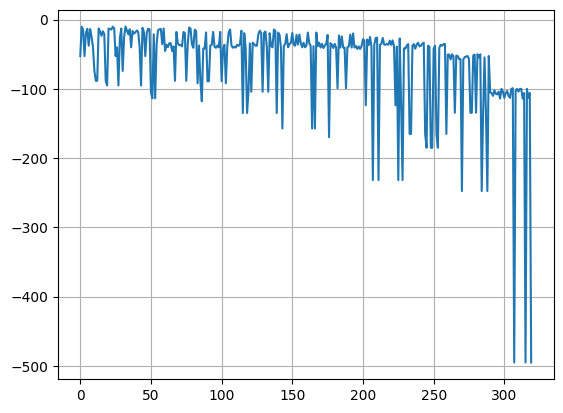

In [119]:
avg_scores = np.array(tot_scores) / np.array(times)

idx_sort = np.argsort(avg_scores)[::-1]

ids = [ids[i] for i in idx_sort]
ps = [ps[i] for i in idx_sort]
p_best = ps[0]
tot_scores = [tot_scores[i] for i in idx_sort]
times = [times[i] for i in idx_sort]
avg_scores = avg_scores[idx_sort]

print(population[0].get_id())
print(ids[:10])
print(times[:10])
print(avg_scores[:10])

idx_sort = np.argsort(ids)[::-1]

ids = [ids[i] for i in idx_sort]
ps = [ps[i] for i in idx_sort]
p_last = ps[0]
tot_scores = [tot_scores[i] for i in idx_sort]
times = [times[i] for i in idx_sort]
avg_scores = avg_scores[idx_sort]

import matplotlib.pyplot as plt

x = ids
y = avg_scores
plt.plot(x, y)
plt.grid()
plt.show()



In [123]:
#ThePlayer = population[0]
ThePlayer = p_best
#ThePlayer = p_last

In [124]:
wins_first = 0
wins_second = 0
n_trials = 1000

player1 = ThePlayer
player2 = RandomPlayer()

for _ in tqdm(range(n_trials)):
    g = Game()

    player1.prepare_to_surrend(500)
    winner = g.play(player1, player2)

    if winner == 0: wins_first += 1

    g = Game()

    player1.prepare_to_surrend(500)
    winner = g.play(player2, player1)

    if winner == 1: wins_second += 1

print(f"Player won {wins_first} / {n_trials} as first")
print(f"Player won {wins_second} / {n_trials} as second")

100%|██████████| 1000/1000 [00:17<00:00, 56.69it/s]

Player won 862 / 1000 as first
Player won 818 / 1000 as second
